# AI Launch Lab - Sea Ice Movement Challenge - PCA and Training

Do some more analysis on the data before choosing our final model.

In [2]:
import pandas as pd
import pickle
import os 
pd.options.mode.chained_assignment = None
import datetime
import numpy as np
import os
import zipfile
import modules.ml_pipeline.readdata as mlpp

Load the data from disk and display it

In [3]:
# unzip the zip dataset
with zipfile.ZipFile('data/converted.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Load the raw data to disk
input_path = "data/converted.csv"
df = pd.read_csv(input_path)

# Convert all column names to lower case and display the dataframe 
df = df.rename(str.lower, axis='columns')
df.set_index("id_buoy")

# Print the dataframe dimensions
print("Dataframe shape: ", df.shape)
display(df)

Dataframe shape:  (329888, 15)


,index,year,month,day,doy,id_buoy,sic_cdr,d2c,ice_thickness,buoy_lat,buoy_lon,buoy_vel_mag,buoy_vel_dir,wind_vel_mag,wind_vel_dir
0,0,1979,2,18,49,1906,0.990195,522.523298,3.189743,78.007070,-128.549129,1.370671,2.191824,6.711849,3.189490
1,1,1979,2,18,49,1913,0.966372,412.767669,2.484009,74.498024,-119.750294,0.741408,0.520564,6.851881,3.240164
2,2,1979,2,18,49,1914,0.996022,362.547379,2.474106,74.003619,-134.786524,1.187695,2.934923,8.896751,3.014921
3,3,1979,2,18,49,1918,0.982681,381.025629,3.740522,81.019593,-145.578020,0.920127,0.028026,1.496117,3.905953
4,4,1979,2,19,50,1906,0.990302,521.535334,3.188522,78.002077,-128.560665,1.300527,1.273525,3.338513,2.278041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329883,339472,2019,12,30,364,25560,1.000000,470.197315,0.933125,75.686986,-96.341501,17.168005,3.811734,8.234026,3.676847
329884,339473,2019,12,30,364,44880,1.000000,702.312813,1.517084,86.513431,-29.153877,11.739478,4.628723,6.522125,4.314615
329885,339474,2019,12,30,364,53005,1.000000,360.491321,1.164462,79.286760,-53.579091,8.973035,3.772087,4.630856,3.224141
329886,339475,2019,12,30,364,95020,1.000000,393.799208,2.010032,79.025667,-135.924079,2.365742,1.967356,2.240471,0.523007


In [4]:
# Do some manipulations on the data and clean it (remove rows of all NaNs, remove duplicates, etc.)

# Remove any rows that have buoy velocity/mag =0 
df = df.drop(df[df["buoy_vel_mag"] == 0].index)
df = df.reset_index()

Define the train/test variables that we will use. 

In [5]:
print("Sea Ice Movement Datasets")

training_targets = df[["buoy_vel_mag","buoy_vel_dir"]]

# We will leave the month for now because it could be an indicator of weather/season 
print("Target Variables")
display(training_targets)

Sea Ice Movement Datasets
Target Variables


,buoy_vel_mag,buoy_vel_dir
0,1.370671,2.191824
1,0.741408,0.520564
2,1.187695,2.934923
3,0.920127,0.028026
4,1.300527,1.273525
...,...,...
329883,17.168005,3.811734
329884,11.739478,4.628723
329885,8.973035,3.772087
329886,2.365742,1.967356


In [6]:
# Drop the time related columns 
training_data = df.drop(["index", "year","day","sic_cdr", "doy", "id_buoy","buoy_vel_mag","buoy_vel_dir"], axis = 1)
display(training_data)

,level_0,month,d2c,ice_thickness,buoy_lat,buoy_lon,wind_vel_mag,wind_vel_dir
0,0,2,522.523298,3.189743,78.007070,-128.549129,6.711849,3.189490
1,1,2,412.767669,2.484009,74.498024,-119.750294,6.851881,3.240164
2,2,2,362.547379,2.474106,74.003619,-134.786524,8.896751,3.014921
3,3,2,381.025629,3.740522,81.019593,-145.578020,1.496117,3.905953
4,4,2,521.535334,3.188522,78.002077,-128.560665,3.338513,2.278041
...,...,...,...,...,...,...,...,...
329883,329883,12,470.197315,0.933125,75.686986,-96.341501,8.234026,3.676847
329884,329884,12,702.312813,1.517084,86.513431,-29.153877,6.522125,4.314615
329885,329885,12,360.491321,1.164462,79.286760,-53.579091,4.630856,3.224141
329886,329886,12,393.799208,2.010032,79.025667,-135.924079,2.240471,0.523007


Split the data into a training and test set.

In [7]:
# test_size: what proportion of original data is used for test set
train_data, test_data, train_labels, test_labels = train_test_split(
    training_data, training_targets, test_size= 0.25, shuffle=True)

# show the sizes of the training and test sets
print("Training data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

print("Training labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Training data shape:  (247416, 8)
Test data shape:  (82472, 8)
Training labels shape:  (247416, 2)
Test labels shape:  (82472, 2)


In [9]:
# Evaluate multioutput regression models
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Split the dataset into training and validation sets. 

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()

# Fit on training set only.
scaler.fit(train_data)

# Apply transform to both the training set and the test set.
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# display the normalized data
display(train_data)

array([[0.18205931, 0.09090909, 0.33876974, ..., 0.11261928, 0.26700406,
        0.05856863],
       [0.7790304 , 0.90909091, 0.1394135 , ..., 0.77887492, 0.20404258,
        0.93424974],
       [0.6799692 , 0.36363636, 0.36849136, ..., 0.13364498, 0.1478348 ,
        0.27981259],
       ...,
       [0.05956888, 0.45454545, 0.39936046, ..., 0.06996811, 0.26815344,
        0.21666204],
       [0.8669211 , 0.81818182, 0.08644922, ..., 0.07076411, 0.10044267,
        0.54875073],
       [0.78388357, 0.90909091, 0.92108019, ..., 0.27390498, 0.23591775,
        0.62334859]])

In [11]:
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100))
regr_multirf.fit(train_data, train_labels)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [12]:
regr_rf = RandomForestRegressor(n_estimators=100,
                                random_state=2)
regr_rf.fit(train_data, train_labels)

RandomForestRegressor(random_state=2)

In [13]:
regr_KNN = KNeighborsRegressor(n_neighbors=20)

regr_KNN.fit(train_data, train_labels)

KNeighborsRegressor(n_neighbors=20)

In [15]:
regr_LR = LinearRegression()
regr_LR.fit(train_data, train_labels)

LinearRegression()

In [17]:
regr_DT = DecisionTreeRegressor()
regr_DT.fit(train_data, train_labels)

DecisionTreeRegressor()

In [18]:
# Calculate the new predictions using the trained models
y_multirf = regr_multirf.predict(test_data)
y_rf = regr_rf.predict(test_data)
y_KNN=regr_KNN.predict(test_data)
y_LR=regr_LR.predict(test_data)
y_DT=regr_DT.predict(test_data)

In [19]:
print(regr_rf.score(test_data,test_labels))
print(regr_multirf.score(test_data, test_labels))
print(regr_KNN.score(test_data, test_labels))
print(regr_LR.score(test_data, test_labels))
print(regr_DT.score(test_data, test_labels))

0.6248173962231615
0.62915769831877
0.5737576951643704
0.34736060559743254
0.25841023740384855


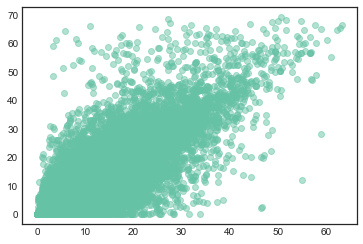

In [ ]:
# Random Forests 

plt.scatter(y_rf, test_labels, alpha=0.5)
plt.show()

# evaluate the model and collect the scores
n_scores = cross_val_score(regr_rf, train_data, train_labels,  scoring='neg_mean_absolute_error', n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

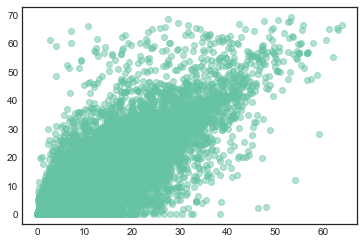

In [21]:
# x and y given as array_like objects
import matplotlib.pyplot as plt

plt.scatter(y_multirf, test_labels, alpha=0.5)
plt.show()


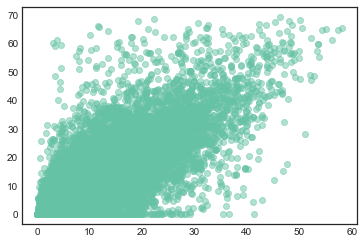

In [22]:
# x and y given as array_like objects
import matplotlib.pyplot as plt

plt.scatter(y_KNN, test_labels, alpha=0.5)
plt.show()

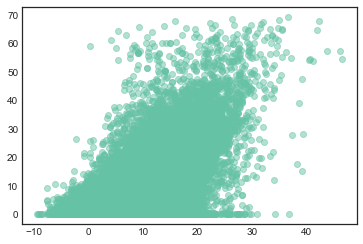

In [23]:
# x and y given as array_like objects
import matplotlib.pyplot as plt

plt.scatter(y_LR, test_labels, alpha=0.5)
plt.show()

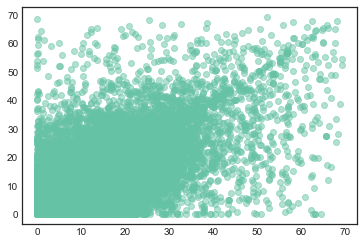

In [24]:
# x and y given as array_like objects
import matplotlib.pyplot as plt

plt.scatter(y_DT, test_labels, alpha=0.5)
plt.show()

## PCA to Speed up Machine Learning Algorithms
(Taken from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data

Normalize the data: 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_data)

# Apply transform to both the training set and the test set.
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# display the normalized data
display(train_data)

In [ ]:
# Choose the minimum percentage of the variables such that 95% of the variance in the dataset is retained
pca = PCA(n_components=4) 

Fit PCA on training set. Note: you are fitting PCA on the training set only

In [ ]:
pca.fit(train_data)

# print the number of components we are left with
print("Number of components: ", pca.n_components_)
print("PCA variance ratio: ", pca.explained_variance_ratio_)

# Transform the data according to the number of principal components
train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

In [ ]:
# Recreate the principal component dataframe: 
principalDf = pd.DataFrame(data = train_data, columns = ['principal component 1', 
                                                         'principal component 2','principal component 3', 'principal component 4'])

# Concatenate the new dataset with the targets
finalDf = pd.concat([principalDf, training_targets], axis = 1)

In [ ]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

Create a series of models and calculate the predictions

Different model choices we can use include Linear Regression, K-Nearest Neighbors, Decision Trees

In [ ]:
# Linear Regression

from sklearn.linear_model import LinearRegression

# define model
model = LinearRegression()
# fit model
model.fit(train_data, train_labels)

In [ ]:
# K-Nearest Neighbors

from sklearn.neighbors import KNeighborsRegressor

# define model
model = KNeighborsRegressor()
# fit model
model.fit(train_data, train_labels)

In [ ]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# define model
model = DecisionTreeRegressor()
# fit model
model.fit(train_data, train_labels)

In [ ]:
# Evaluate the model with K-Cross Validation

IMPORT K-FOLD
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_data, train_labels,  scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#model.predict(test_data, test_labels)
